# Fifth Homework - Permutation-based Variable Importance

First descriptive part of this homework is provided in the form of pdf document.


##Part 2. Code

###Dependencies

In [ ]:
!pip install dalex
!pip install lime
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 24.8 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043321 sha256=812f00f65da3a3fa4dd3a0c4013c97b1c063dfb00e1434c5a0eea4c2f6522ab8
  Stored in directory: /root/.cache/pip/wheels/76/31/8c/c78df586df31b3f3e0c4ecc759ee73e175545cff5548201996
Successfully built dalex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 8.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=0f95ea94b97dee00842a069ecd7fe0ca3ad233f660f919edf1274391a5772487
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import shap
import dalex as dx

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import random

###Downloading Dataset
Firstly, in order to download Alcohol Effects on Study dataset, we mount google drive and upload kaggle API.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

Mounted at /content/gdrive


In [ ]:
files.upload() #this will prompt you to upload the kaggle.jso

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paulinakaczyska","key":"a590f81fa200cd408d5cb174df96882a"}'}

In [ ]:
#make sure kaggle.json file is present
!ls -lha kaggle.json

#Install kaggle API client
!pip install -q kaggle

#kaggle API client expects the file to be in ~/.kaggle

#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#seting permissions
!chmod 600 /root/.kaggle/kaggle.json

#check your directory before downloading the datasets
!pwd

#downloading
!kaggle datasets download -d whenamancodes/alcohol-effects-on-study

#unzipping
!unzip alcohol-effects-on-study.zip

-rw-r--r-- 1 root root 71 Nov 22 13:58 kaggle.json
/content
  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 15.8MB/s]
Archive:  alcohol-effects-on-study.zip
  inflating: Maths.csv               
  inflating: Portuguese.csv          


### Data Preprocessing

In [ ]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus','schoolsup', 'famsup', 'paid', 'activities', 'nursery','higher', 'internet', 'romantic']
categorical_nb = ['Mjob', 'Fjob', 'reason', 'guardian']
numerical = ['Medu', 'Fedu','traveltime', 'studytime','failures','famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

The categorical data are one-hot encoded. Data is divided to input and output.

In [ ]:
math = pd.read_csv("Maths.csv", encoding = "UTF-8")
port = pd.read_csv("Portuguese.csv", encoding = "UTF-8")

math_i_c = pd.get_dummies(math[binary+categorical_nb],drop_first = True)
port_i_c = pd.get_dummies(port[binary+categorical_nb],drop_first = True)

math_o = math.iloc[:,-1]
port_o = port.iloc[:,-1]


In [ ]:
math

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


Data is combined into input X and output Y arrays.

In [ ]:

math_array = pd.concat([math_i_c,math[numerical]],axis=1)
port_array = pd.concat([port_i_c,port[numerical]],axis=1)
X = pd.concat((math_array,port_array),axis = 0).reset_index().drop(['index'],axis=1)
Y = pd.concat((math_o,port_o),axis = 0).reset_index().drop(['index'],axis=1)


Division for test and train dataset is made using train_test_split from sklearn library.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=100, train_size=len(X)-100)

###Permuttation-based Variable Importance on Random Forest Regressor

Firstly, I train Random Forest Regression using function from sklearn package. This method is a tree ensemble method. 

In [ ]:
model_rfr = RandomForestRegressor(n_estimators = 300, max_depth=4, random_state=0)
model_rfr.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
def pf_rfr(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])
    return model.predict(df)

explainer_rfr = dx.Explainer(model_rfr, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 100 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f83e3126680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.67, mean = 11.3, max = 12.9
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -11.9, mean = 0.294, max = 6.49
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [ ]:
pvi = explainer_rfr.model_parts(random_state=0)

In [ ]:
pvi.result

,variable,dropout_loss,label
0,Mjob_teacher,3.152351,RandomForestRegressor
1,paid_yes,3.152572,RandomForestRegressor
2,famrel,3.157183,RandomForestRegressor
3,goout,3.159099,RandomForestRegressor
4,Walc,3.161041,RandomForestRegressor
5,Fedu,3.161774,RandomForestRegressor
6,famsup_yes,3.162357,RandomForestRegressor
7,Fjob_health,3.162391,RandomForestRegressor
8,guardian_mother,3.162426,RandomForestRegressor
9,Fjob_other,3.162475,RandomForestRegressor


In [ ]:
pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

Now I check the Random Forest regressor with different parameters:

In [ ]:
model_rfr2 = RandomForestRegressor(n_estimators = 100, max_depth=8)
model_rfr2.fit(X_train, y_train)

explainer_rfr2 = dx.Explainer(model_rfr2, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Preparation of a new explainer is initiated

  -> data              : 100 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f83e3126680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.69, mean = 11.3, max = 13.9
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -11.5, mean = 0.302, max = 6.58
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



In [ ]:
pvi2 = explainer_rfr2.model_parts(random_state=0)
pvi2.plot(show=False).update_layout(autosize=False, width=600, height=450)

###PVI on Linear Regression

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

In [ ]:
explainer_lr = dx.Explainer(model_lr,X_test,y_test)

Preparation of a new explainer is initiated

  -> data              : 100 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> model_class       : sklearn.linear_model._base.LinearRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f83e3126680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.33, mean = 11.3, max = 14.1
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -14.1, mean = 0.361, max = 14.7
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/usr/local/lib/python3.7/dist-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



In [ ]:
pdp_lr = explainer_lr.model_parts()
pdp_lr.plot(show=False).update_layout(autosize=False, width=600, height=450)

#PVI on SGD Regressor

In [ ]:
 from sklearn.linear_model import SGDRegressor
 model_sgdr = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000).fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
explainer_sgd = dx.Explainer(model_sgdr,X_test,y_test)

Preparation of a new explainer is initiated

  -> data              : 100 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> model_class       : sklearn.linear_model._stochastic_gradient.SGDRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f83e3126680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.29, mean = 11.8, max = 15.2
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -13.4, mean = -0.14, max = 6.92
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but SGDRegressor was fitted with feature names



In [ ]:
pdp_sgd = explainer_sgd.model_parts()
pdp_sgd.plot(show=False).update_layout(autosize=False, width=600, height=450)

#Comparison of Gini, SHAP and PVI on Random Forest

In [ ]:
model_rfr.feature_importances_

array([0.00809699, 0.00503778, 0.00501103, 0.00392834, 0.00110331,
       0.04736516, 0.00073603, 0.02490531, 0.00217751, 0.00309169,
       0.0219535 , 0.00352067, 0.00718845, 0.00533826, 0.00267259,
       0.00288835, 0.00959333, 0.00066874, 0.00084618, 0.00356362,
       0.01629304, 0.00395237, 0.00165242, 0.0092288 , 0.00232739,
       0.02272355, 0.02087299, 0.01661441, 0.00763424, 0.02426319,
       0.42259013, 0.00979158, 0.02853686, 0.01937152, 0.01616344,
       0.0093231 , 0.02149904, 0.1874751 ])

In [ ]:
X_test.columns

Index(['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'schoolsup_yes', 'famsup_yes', 'paid_yes', 'activities_yes',
       'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')

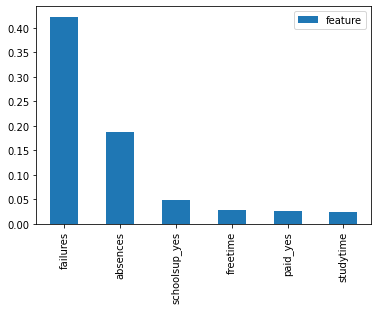

In [ ]:
pd.DataFrame(data=model_rfr.feature_importances_,index = X_test.columns,columns = ['feature']).sort_values(by='feature',ascending = False).head(6).plot.bar()

Biggest contribution have the features: number of 

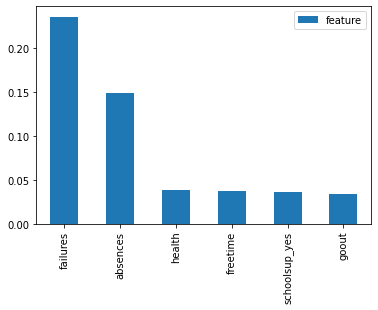

In [ ]:
pd.DataFrame(data=model_rfr2.feature_importances_,index = X_test.columns,columns = ['feature']).sort_values(by='feature',ascending = False).head(6).plot.bar()

In [ ]:
shap_explainer = shap.explainers.Tree(model_rfr, data=X_test)

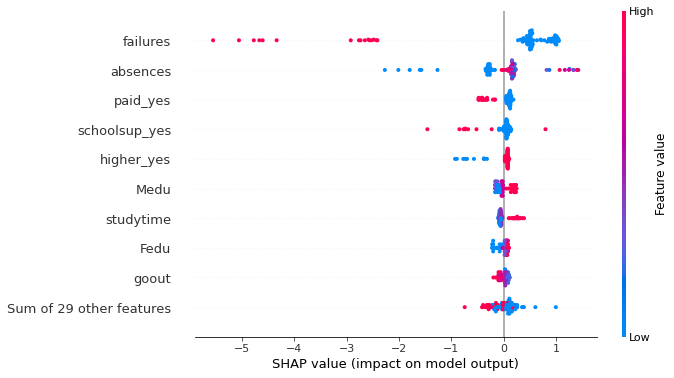

In [ ]:
shap_values = shap_explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=10, plot_size=(9, 6))

In [ ]:
%%shell
jupyter nbconvert --to html ///content/XAI_HW5.ipynb

[NbConvertApp] WARNING | pattern '///content/XAI_HW5.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec

CalledProcessError: ignored